In [1]:
# python lib
import os
import shutil
import sys
import subprocess
import time
original_directory = os.getcwd()
# import alolib
from alolib.asset import Asset
from alolib.exception import print_color

# local import
os.chdir(os.path.abspath(os.path.join('..')))
from common import Logger, print_color, find_matching_strings, asset_info, extract_requirements_txt, check_install_requirements


In [2]:
# !make clean

In [3]:
# !make del

In [4]:
os.chdir(os.path.abspath(os.path.join(original_directory)))

In [8]:
# 현재 위치 확인

PROJECT_HOME = os.path.dirname(os.getcwd())
# experimental plan yaml의 위치
EXP_PLAN = PROJECT_HOME + "/config/experimental_plan.yaml"
# asset 코드들의 위치
SCRIPT_HOME = PROJECT_HOME + "/assets/"

envs = {}
envs['project_home'] = PROJECT_HOME + "/"

SUPPORT_TYPE = ['memory', 'file']

In [9]:
req_list = extract_requirements_txt("master")
master_req = {"master": req_list}
check_install_requirements(master_req)

======================================== Start dependency installation - step : << master >> ========================================
>> Start checking existence & installing package - alolib@git+http://mod.lge.com/hub/dxadvtech/alolib-dev.git@develop | Progress: ( 1 / 1 total packages )
- << alolib@git+http://mod.lge.com/hub/dxadvtech/alolib-dev.git@develop >> already exists
======================================== Finish dependency installation ======================================== 



In [10]:
# asset init
asset = Asset(envs=envs, argv=0, version=0.1)

In [11]:
# configure setting
asset.get_yaml(EXP_PLAN)
external_path = asset.get_external_path()
external_path_permission = asset.get_external_path_permission()
pipelines_list = asset.get_pipeline()
user_parameters = asset.get_user_parameters()
controls = asset.get_control()
artifacts = asset.set_artifacts()

In [12]:
# 외부 데이터 다운로드 (input 폴더에)
asset.fetch_data(external_path, external_path_permission)

>> s3 private key file << load_s3_key_path >> loaded successfully.
>> Start fetching external data from << /nas001/users/yoonji.suh/tcr_test_20231011/train_missing/ >> into << input >> folder.
>> Start fetching external data from << /nas001/users/yoonji.suh/tcr_test_20231011/inf/ >> into << input >> folder.


In [13]:
pipe_mode = 'train_pipeline'

In [14]:
####################### ALO master requirements 리스트업 #######################
# ALO master requirements 는 최우선 순위로 설치 > 만약 ALO master requirements는 aiplib v2.1인데 slave 제작자가 aiplib v2.2로 명시해놨으면 2.1이 우선 
requirements_dict = dict() 
requirements_dict['master'] =  extract_requirements_txt(step_name = 'master')
####################### Slave Asset 설치 및 Slave requirements 리스트업 #######################

# setup asset (asset을 git clone (or local) 및 requirements 설치)
get_asset_source = controls["get_asset_source"]  # once, every
for step, asset_config in enumerate(pipelines_list[pipe_mode]):
    # self.asset.setup_asset 기능 :
    # local or git pull 결정 및 scripts 폴더 내에 위치시킴 
    asset.setup_asset(asset_config, get_asset_source)
    requirements_dict[asset_config['step']] = asset_config['source']['requirements']
    # local 모드일 땐 이번 step(=asset)의 종속 package들이 내 환경에 깔려있는 지 항상 체크 후 없으면 설치 
    # git 모드일 땐 every이거나 once면서 첫 실행 시에만 requirements 설치 

####################### Master & Slave requirements 설치 #######################
# 이미 asset (step) 폴더들은 input 폴더에 다 setup된 상태 
# 각 asset의 yaml에 직접 작성 된 패키지들 + asset 내의 requirements.txt를 참고하여 쭉 리스트업 
# asset 간 중복 패키지 존재 시 먼저 실행되는 pipeline, asset에 대해 우선순위 부여하여 설치되게끔   
# 패키지 설치 중에 진행중인 asset 단계 표시 및 총 설치 중 몇번 째 설치인지 표시 > pipeline 별로는 별도로 진행 
asset.check_install_requirements(requirements_dict) 

input asset has already been created at 2023-10-12 23:55:51.822939
preprocess asset has already been created at 2023-10-12 23:55:52.455943
sampling asset has already been created at 2023-10-12 23:55:53.107947
train asset has already been created at 2023-10-12 23:55:53.563950
Ignored installing << pandas==1.5.3 >>. Another version will be installed in the previous step.
Ignored installing << pandas==1.5.3 >>. Another version will be installed in the previous step.
Ignored installing << pandas==1.5.3 >>. Another version will be installed in the previous step.
Ignored installing << scikit-learn >>. Another version will be installed in the previous step.
Ignored installing << numpy==1.25.2 >>. Another version will be installed in the previous step.
======================================== Start dependency installation - step : << master >> ========================================
>> Start checking existence & installing package - alolib@git+http://mod.lge.com/hub/dxadvtech/alolib-dev.git@d

In [15]:
check_asset_source = controls["get_asset_source"]

In [33]:
def run(step, pipelines, data, config):
    asset_config = pipelines_list[pipelines][step]
    asset.setup_asset(asset_config, check_asset_source)
    
    asset_info(pipelines, asset_config['step'])
    
    # scripts 폴더에 있는 내용을 가져와 import 한다
    _path = SCRIPT_HOME + asset_config['step'] + "/"
    _file = "asset_" + asset_config['step']
    user_asset = asset.import_asset(_path, _file)
    
    if controls['interface_mode'] in SUPPORT_TYPE:
        # 첫 동작시에는 초기화하여 사용 
        if step == 0:
            data = 0
            config = {}
        else:
            if controls['interface_mode'] == 'memory':
                pass
            elif controls['interface_mode'] == 'file':
                data, config = self.asset.get_toss(_pipe_num, envs) # file interface
    else:
        return ValueError("only file and memory")
    
    args = user_parameters[pipelines][step]['args']
    
    envs = {}
    envs['project_home'] = PROJECT_HOME
    envs['pipeline'] = pipelines
    envs['step'] = user_parameters[pipelines][step]['step']
    envs['artifacts'] = artifacts
    
    ua = user_asset(envs, args[0], data, config)
    data, config = ua.run()
    
    
    # self.asset.save_file(data)

    sys.path = [item for item in sys.path if envs['step'] not in item]

    if controls['interface_mode'] == 'file':
        asset.toss(data, config, pipelines, envs)
    else:
        return data, config

In [26]:
data = 0
confg = 0

In [27]:
pipelines = 'train_pipeline'

In [28]:
step = 0
data, config = run(step, pipelines, data, config)

input asset has already been created at 2023-10-12 23:59:29.508387



============================= ASSET INFO =============================
PIPELINES    : train_pipeline
ASSETS       : input



==================== current time : 2023-10-12 23:59:39.167988+00:00 (UTC) ====================
************************************************************
************************************************************
>> Load path : ['/home/jovyan/repo/alov2/input/train_missing/']
>> The file for batch data has been loaded. (File name: /home/jovyan/repo/alov2/input/train_missing/BF_stat.csv)
==================== Success loading dataframe ====================
>> Drop columns from the input dataframe when set << auto >> mode or specified in the << drop_columns >> in config yaml. (dropped colums:[])


In [29]:
# step: 현재 동작중인 asset number
def make_envs(step):
    envs = {}
    envs['pipeline'] = pipelines
    envs['step'] = user_parameters[pipelines][step]['step']
    envs['artifacts'] = artifacts
    return envs

In [31]:
# read data from file
# get_toss(pipelines, envs)
# pipelines: 현재 동작중인 파이프라인 이름
# 현재 동작중인 환경 설정
if controls['interface_mode'] == 'file':
    data, config = asset.get_toss(pipelines, make_envs(step))

In [34]:
step = 1
data, config = run(step, pipelines, data, config)

preprocess asset has already been created at 2023-10-13 00:00:33.186811



============================= ASSET INFO =============================
PIPELINES    : train_pipeline
ASSETS       : preprocess



Got model path for saving or loading: 
 /home/jovyan/repo/alov2/.train_artifacts/models/preprocess/
************************************************************
************************************************************
label column : label Encoder saved : /home/jovyan/repo/alov2/.asset_interface/
['Count_nan', 'Converted Torque_nan', 'angle_min_nan', 'angle_mean_nan', 'angle_median_nan', 'angle_std_nan', 'angle_max_nan', 'torque_min_nan', 'torque_mean_nan', 'torque_median_nan', 'torque_std_nan', 'torque_max_nan'] label_encoded_nan


fatal: No names found, cannot describe anything.


In [35]:
step = 2
data, config = run(step, pipelines, data, config)

sampling asset has already been created at 2023-10-12 23:55:53.107947



============================= ASSET INFO =============================
PIPELINES    : train_pipeline
ASSETS       : sampling





/home/jovyan/conda/envs/alov2-dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-13 00:01:00.623993: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 00:01:00.771227: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-10-13 00:01:00.771272: I tensorflo

************************************************************
************************************************************


train asset has already been created at 2023-10-12 23:55:53.563950



============================= ASSET INFO =============================
PIPELINES    : train_pipeline
ASSETS       : train



************************************************************
************************************************************
Got model path for saving or loading: 
 /home/jovyan/repo/alov2/.train_artifacts/models/train/
Got output path for saving or loading: 
 /home/jovyan/repo/alov2/.train_artifacts/output/train/
해당 column 은 Training 과정에 사용되지 않습니다. (column_name: ['torque_mean', 'angle_min', 'label', 'torque_min', 'angle_median', 'label_encoded', 'Count', 'angle_max', 'torque_max', 'label_encoded_nan', 'angle_std', 'angle_mean', 'torque_median', 'torque_std', 'Converted Torque'])
 Y 칼럼 ( ['y0'] )의 데이터 타입은 dict_values([dtype('int64')]) 입니다. 분석을 위해, Y 칼럼의 타입이 'int' 혹은 'float' 이어야 합니다.                 데이터 중 Y 칼럼의 모든 값이 숫자로 구성되어 있는지 확인해주세요. 만약, Y 칼럼이 카테고리 칼럼이라면, Preprocess 단계에서 해당 칼럼을 숫자로 변환하는 과정이 필요합


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[INFO] 0th-fold RandomForestClassifier_set0 모델을 학습합니다.(1/48)
[INFO] 1th-fold RandomForestClassifier_set0 모델을 학습합니다.(2/48)
[INFO] 2th-fold RandomForestClassifier_set0 모델을 학습합니다.(3/48)
[INFO] 3th-fold RandomForestClassifier_set0 모델을 학습합니다.(4/48)
[INFO] 0th-fold RandomForestClassifier_set1 모델을 학습합니다.(5/48)
[INFO] 1th-fold RandomForestClassifier_set1 모델을 학습합니다.(6/48)
[INFO] 2th-fold RandomForestClassifier_set1 모델을 학습합니다.(7/48)
[INFO] 3th-fold RandomForestClassifier_set1 모델을 학습합니다.(8/48)
[INFO] 0th-fold RandomForestClassifier_set2 모델을 학습합니다.(9/48)
[INFO] 1th-fold RandomForestClassifier_set2 모델을 학습합니다.(10/48)
[INFO] 2th-fold RandomForestClassifier_set2 모델을 학습합니다.(11/48)
[INFO] 3th-fold RandomForestClassifier_set2 모델을 학습합니다.(12/48)
[INFO] 0th-fold GradientBoostingClassifier_set0 모델을 학습합니다.(13/48)
[INFO] 1th-fold GradientBoostingClassifier_set0 모델을 학습합니다.(14/48)
[INFO] 2th-fold GradientBoostingClassifier_set0 모델을 학습합니다.(15/48)
[INFO] 3th-fold GradientBoostingClassifier_set0 모델을 학습합니다.(16/48)
[

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


[INFO] 0th-fold CatBoostClassifier_set1 모델을 학습합니다.(41/48)


iteritems is deprecated and will be removed in a future version. Use .items instead.


[INFO] 1th-fold CatBoostClassifier_set1 모델을 학습합니다.(42/48)


iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


[INFO] 2th-fold CatBoostClassifier_set1 모델을 학습합니다.(43/48)


iteritems is deprecated and will be removed in a future version. Use .items instead.


[INFO] 3th-fold CatBoostClassifier_set1 모델을 학습합니다.(44/48)


iteritems is deprecated and will be removed in a future version. Use .items instead.


[INFO] 0th-fold CatBoostClassifier_set2 모델을 학습합니다.(45/48)


iteritems is deprecated and will be removed in a future version. Use .items instead.


[INFO] 1th-fold CatBoostClassifier_set2 모델을 학습합니다.(46/48)
[INFO] 2th-fold CatBoostClassifier_set2 모델을 학습합니다.(47/48)
[INFO] 3th-fold CatBoostClassifier_set2 모델을 학습합니다.(48/48)


iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


@scoring_classification func. - label list: @scoring_classification func. - label list: @scoring_classification func. - label list: @scoring_classification func. - label list: @scoring_classification func. - label list: @scoring_classification func. - label list: @scoring_classification func. - label list: @scoring_classification func. - label list: @scoring_classification func. - label list: @scoring_classification func. - label list:   @scoring_classification func. - label list:    @scoring_classification func. - label list:     {0, 1} {0, 1} {0, 1}{0, 1}{0, 1}{0, 1}{0, 1} {0, 1}{0, 1}{0, 1}
{0, 1}







{0, 1}




The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


[INFO] 평가 지표는 ( accuracy ) 를 사용합니다. 
모델 정보 로그를 저장합니다. (저장위치: /home/jovyan/repo/alov2/.train_artifacts/models/train/model_selection.json)
모델 파일을 저장합니다. (저장위치: /home/jovyan/repo/alov2/.train_artifacts/models/train/best_model_top0.pkl)
모델 파일을 저장합니다. (저장위치: /home/jovyan/repo/alov2/.train_artifacts/models/train/best_model_top1.pkl)
모델 파일을 저장합니다. (저장위치: /home/jovyan/repo/alov2/.train_artifacts/models/train/best_model_top2.pkl)
[INFO] Summary_plot for Train data 를 저장했습니다.



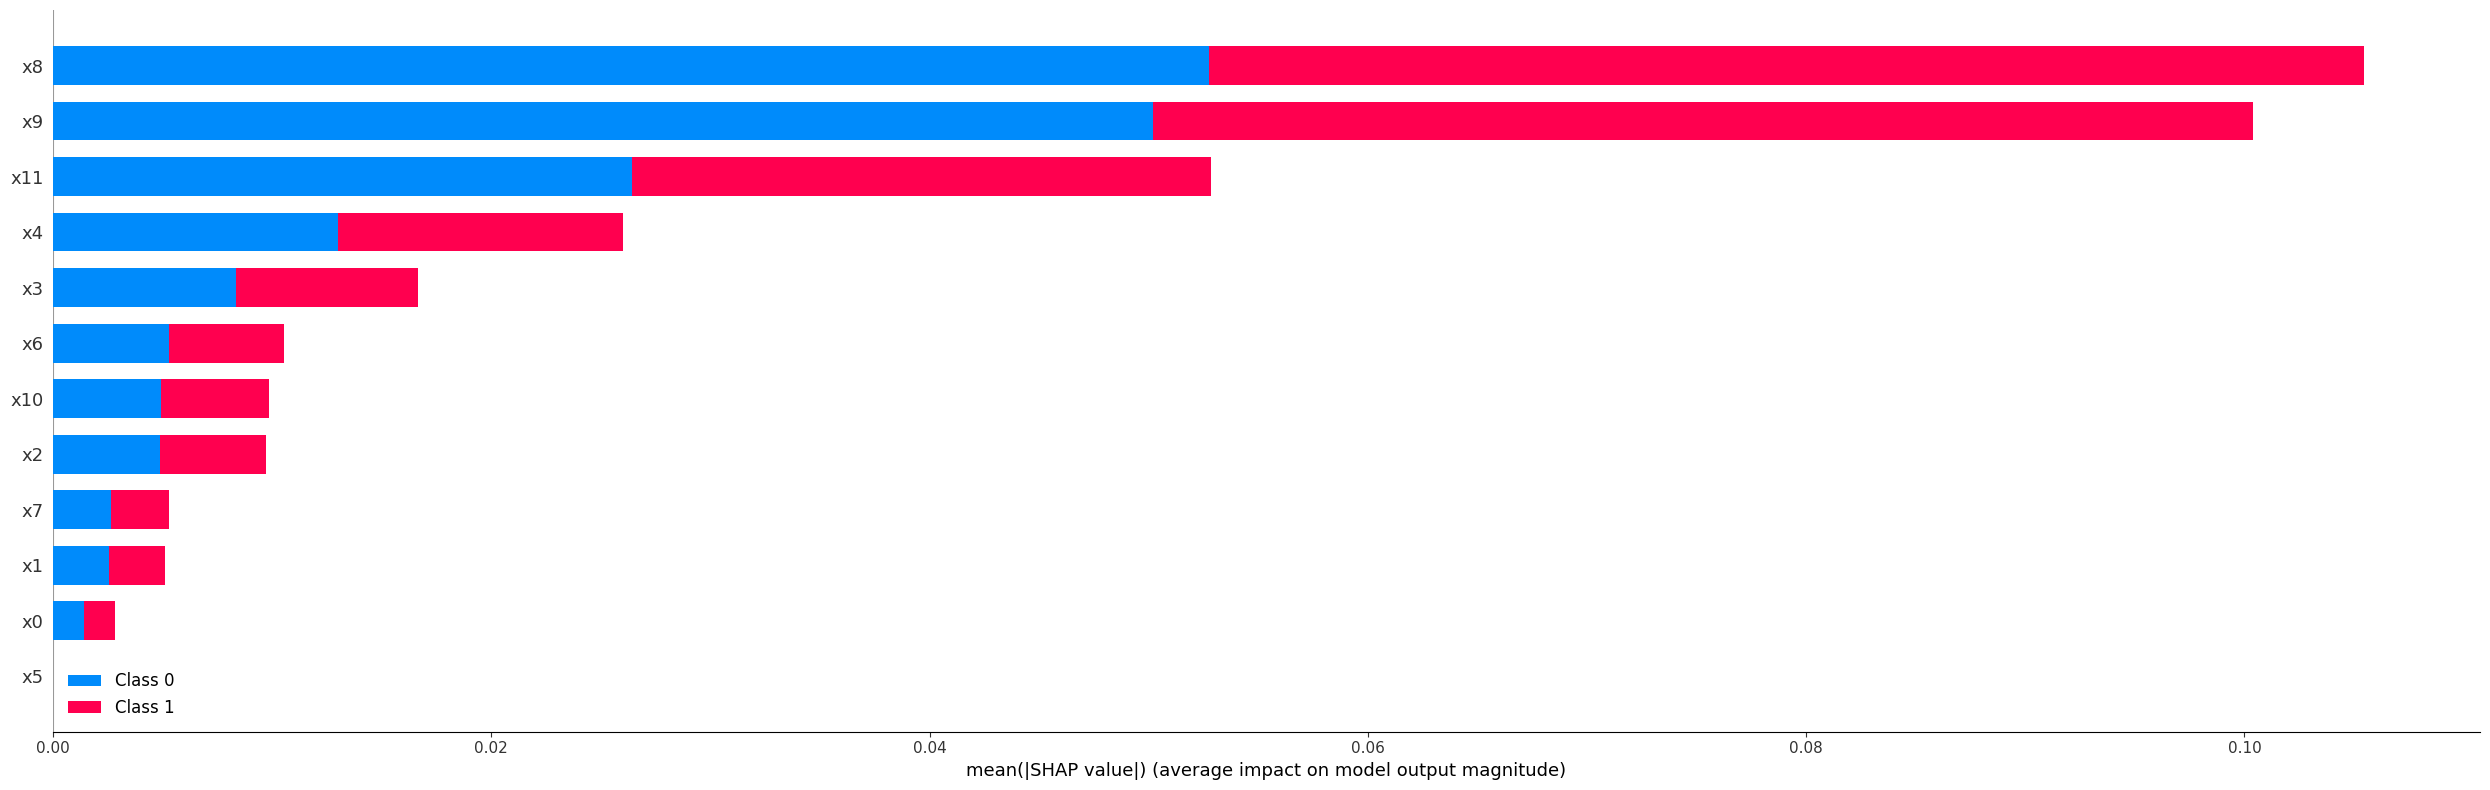

In [36]:
# 넘어가면 실행이 안됨
step = 3
data, config = run(step, pipelines, data, config)

In [37]:
data, config = run(0, 'inference_pipeline', data, config)

input asset has already been created at 2023-10-12 23:59:29.508387



============================= ASSET INFO =============================
PIPELINES    : inference_pipeline
ASSETS       : input



==================== current time : 2023-10-13 00:01:36.341468+00:00 (UTC) ====================
************************************************************
************************************************************
>> Load path : ['/home/jovyan/repo/alov2/input/inf/']
>> The file for batch data has been loaded. (File name: /home/jovyan/repo/alov2/input/inf/BF_dup.csv)
>> The file for batch data has been loaded. (File name: /home/jovyan/repo/alov2/input/inf/BF_stats_inf.csv)
==================== Success loading dataframe ====================
>> Drop columns from the input dataframe when set << auto >> mode or specified in the << drop_columns >> in config yaml. (dropped colums:[])


In [38]:
run(1, 'inference_pipeline', data, config)

@ local asset_source_code mode: <preprocess> asset exists.



============================= ASSET INFO =============================
PIPELINES    : inference_pipeline
ASSETS       : preprocess



Got model path for saving or loading: 
 /home/jovyan/repo/alov2/.train_artifacts/models/preprocess/
************************************************************
************************************************************
['Count_nan', 'Converted Torque_nan', 'angle_min_nan', 'angle_mean_nan', 'angle_median_nan', 'angle_std_nan', 'angle_max_nan', 'torque_min_nan', 'torque_mean_nan', 'torque_median_nan', 'torque_std_nan', 'torque_max_nan'] 


fatal: No names found, cannot describe anything.


({'dataframe':    Count  Converted Torque  angle_min   angle_mean  angle_median    angle_std  \
  0  517.0              6.04        0.0  2538.899420        2657.0  1574.932713   
  1  519.0              6.05        0.0  2549.233141        2669.0  1579.921028   
  2  492.0              6.04        0.0  2421.243902        2507.0  1520.566223   
  3  517.0              6.04        0.0  2538.899420        2657.0  1574.932713   
  4  519.0              6.05        0.0  2549.233141        2669.0  1579.921028   
  5  492.0              6.04        0.0  2421.243902        2507.0  1520.566223   
  
     angle_max  torque_min  torque_mean  torque_median  ...  angle_min_nan  \
  0     4777.0        0.00     1.114023           0.85  ...            0.0   
  1     4800.0       -0.01     1.107495           0.99  ...            0.0   
  2     4579.0       -0.01     1.411626           1.28  ...            0.0   
  3     4777.0        0.00     1.114023           0.85  ...            0.0   
  4     4800.

In [ ]:
#위에 생성된 data와 config를 이용해 다음 step을 진행

In [ ]:
# input asset이 아닌 경우 data와 전역 변수 config가 필요하다
# data의 경우 현재 step에서 사용할 data를 넣는다고 생각하면 된다
# import pandas as pd
# data = pd.read_csv("/home/jovyan/repo/alov2/train_data/bolt_train_data.csv")